In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu

Start import
Working on midway2-0417.rcc.local with the following versions 
and installation paths:
strax
	v0.13.8	/dali/lgrandi/strax/strax/strax
straxen
	v0.15.1	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [5]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning_kr*',
                       available=('event_info','peak_basics'))
dsets = dsets[(dsets.end > pd.to_datetime('02/01/2021'))]
dsets = dsets[(dsets.end < pd.to_datetime('02/16/2021'))]
print('total number of runs:', len(dsets))

total number of runs: 20


In [6]:
dsets

,name,number,mode,end,start,tags,livetime,raw_records_available,peak_basics_available,event_info_available
620,012486,12486,tpc_commissioning_kr83m,2021-02-03 12:20:44.119,2021-02-03 11:20:44.023,,0 days 01:00:00.096000,False,True,True
622,012484,12484,tpc_commissioning_kr83m,2021-02-03 11:17:30.799,2021-02-03 10:33:56.327,,0 days 00:43:34.472000,False,True,True
624,012482,12482,tpc_commissioning_kr83m,2021-02-03 09:59:22.669,2021-02-03 09:41:08.543,,0 days 00:18:14.126000,False,True,True
625,012481,12481,tpc_commissioning_kr83m,2021-02-03 09:40:54.341,2021-02-03 08:40:53.778,,0 days 01:00:00.563000,False,True,True
630,012476,12476,tpc_commissioning_kr83m,2021-02-03 03:03:21.034,2021-02-03 02:03:20.485,,0 days 01:00:00.549000,False,True,True
631,012475,12475,tpc_commissioning_kr83m,2021-02-03 02:03:06.291,2021-02-03 01:03:05.086,,0 days 01:00:01.205000,False,True,True
632,012474,12474,tpc_commissioning_kr83m,2021-02-03 01:02:50.796,2021-02-03 00:02:49.009,,0 days 01:00:01.787000,False,True,True
633,012473,12473,tpc_commissioning_kr83m,2021-02-03 00:02:34.819,2021-02-02 23:02:32.038,,0 days 01:00:02.781000,False,True,True
634,012472,12472,tpc_commissioning_kr83m,2021-02-02 23:02:17.847,2021-02-02 22:02:15.793,,0 days 01:00:02.054000,False,True,True
636,012470,12470,tpc_commissioning_kr83m,2021-02-02 22:02:01.603,2021-02-02 21:02:01.310,,0 days 01:00:00.293000,False,True,True


# Kr-83m data

In [19]:
def plot_area_width_aft(events, run_id, low = 0, high = 6, low2 = 0, high2 = 1, binning = 500):
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')

Loading event_info_double: |          | 0.00 % [00:00<?]

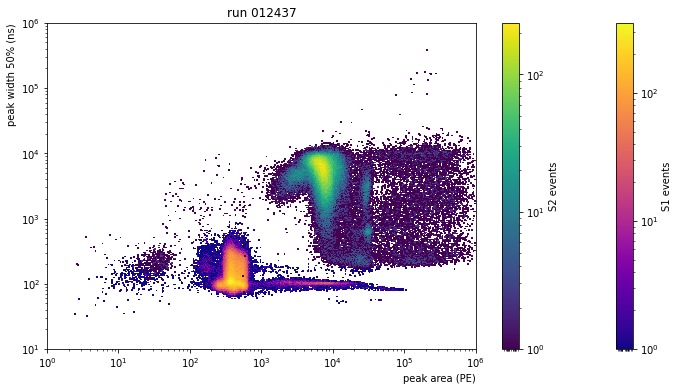

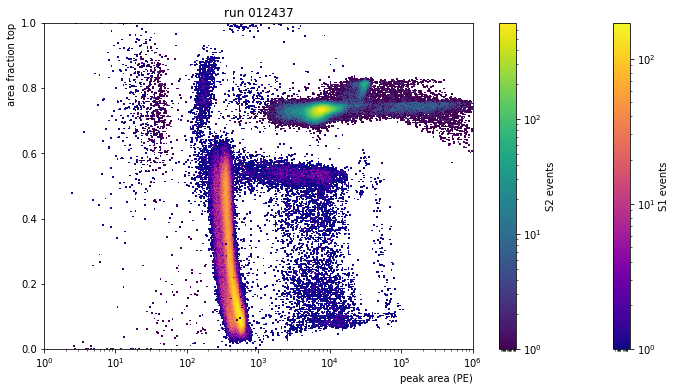

In [57]:
run_kr = '012437'  #2021-01-28 14:00 new data with a liquid level of ~5.5 mm
events = st.get_array(run_kr,'event_info_double')
plot_area_width_aft(events,run_kr)

# Cut on Single S1 (from Maxime)

In [4]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

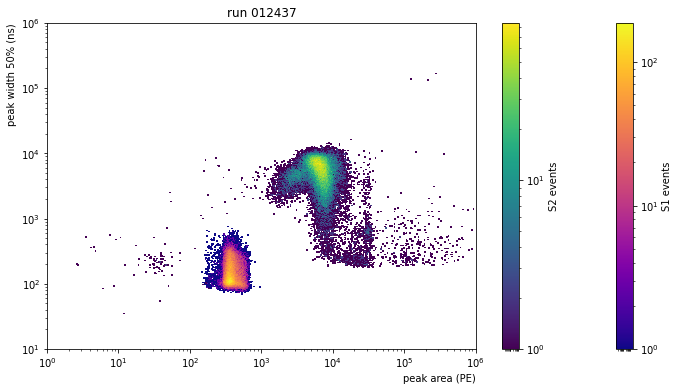

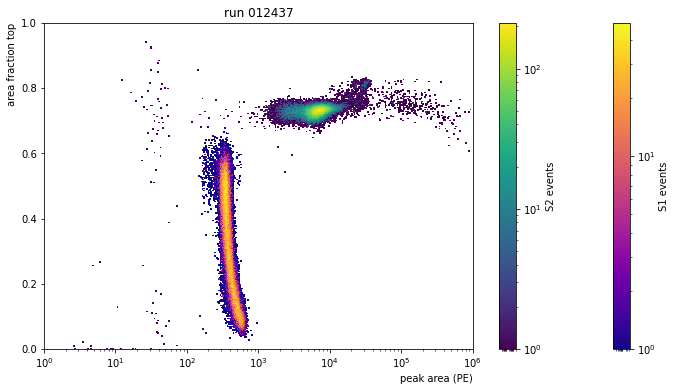

In [89]:
mask_KrS1 = mask_KrSingleS1(events)
plot_area_width_aft(events[mask_KrS1], run_kr)

# Cut on S2 Area, Width and Area Fraction Top

In [193]:
def mask_s2_area_width_aft(events, run_id, area_cut, width_cut,aft_cut,
                          low = 1, high = 6, low2 = 2, high2 = 4.5, low3 = 0.4, high3 = 0.9, binning=500):
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    plt.yscale('log')
    psu.rectangle(area_cut, width_cut, 'r')
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(low3, high3, binning)))
    plt.figure(figsize=(12,6))
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'run {run_id}')
    plt.xscale('log')
    psu.rectangle(area_cut, aft_cut, 'r')
    mask = (events['s2_a_area'] > area_cut[0]) & (events['s2_a_area'] < area_cut[1])
    mask &= (events['s2_a_range_50p_area'] > width_cut[0]) & (events['s2_a_range_50p_area'] < width_cut[1])
    mask &= (events['s2_a_area_fraction_top'] > aft_cut[0]) & (events['s2_a_area_fraction_top'] < aft_cut[1])
    return mask

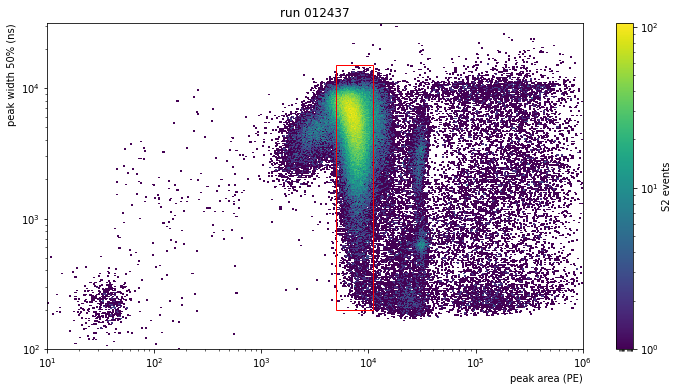

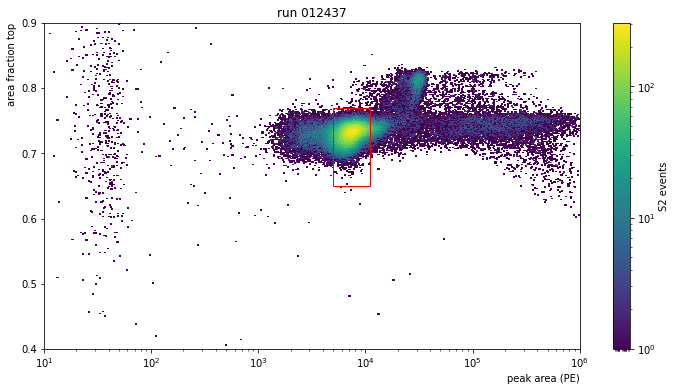

In [194]:
mask_awt = mask_s2_area_width_aft(events,run_kr,area_cut=(5e3,1.1e4),width_cut=(200,1.5e4),aft_cut=(0.65,0.77))

In [87]:
def s2_width_vs_dt(dt,s2width, run_id):
    t = np.linspace(0, 3000, 200)
    ph = Histdd(dt, s2width,bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)

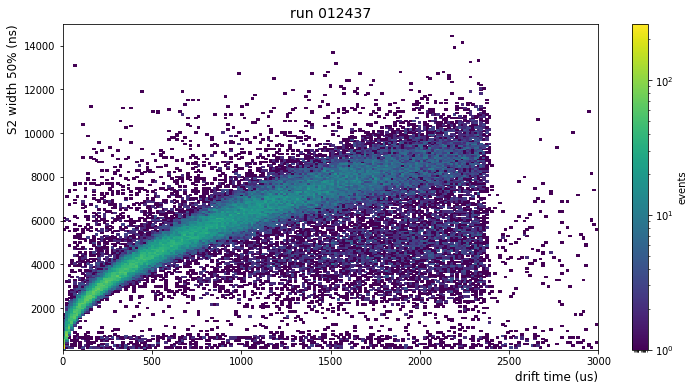

In [96]:
e1 = events[mask_KrS1]
s2_width_vs_dt(e1['drift_time']/1e3,e1['s2_a_range_50p_area'],run_kr)

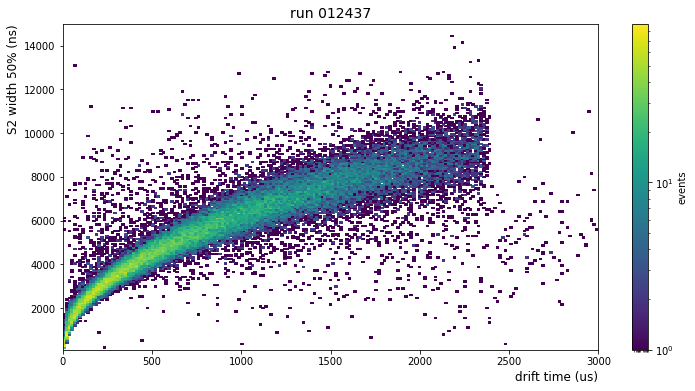

In [131]:
e2 = events[mask_KrS1 & mask_awt]
s2_width_vs_dt(e2['drift_time']/1e3,e2['s2_a_range_50p_area'],run_kr)

# Drift Velocity

In [183]:
def drift_velocity(events, run_id, low = 0, high = 2600, binning = 500,perc=1):
    plt.figure(figsize=(12,6))
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    hdtime.plot(color='b',label='data')
    plt.ylabel("events", ha='right', y=1)
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
    plt.yscale('log')
    dropoff = dt[np.where(np.array(hdtime)>50)[0][-1]]
    plt.axvline(x=dropoff,linewidth=1,linestyle='--', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(12,6))
    area_ratio = np.divide(events['cs2_a'],events['cs1_a'])
    mh = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(np.linspace(low, high, binning), np.logspace(0, 5, 200)))
    mh.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    plt.yscale('log')
    plt.xlim(2e3,high)
    plt.axvline(x=dropoff,linewidth=1,linestyle='-', color='r',label=f'cathode drop-off = {dropoff:.1f} us')
    plt.axvline(x=dropoff+dropoff*perc/100,linewidth=1,linestyle='--', color='r')
    plt.axvline(x=dropoff-dropoff*perc/100,linewidth=1,linestyle='--', color='r')
    
    plt.figure(figsize=(12,6))
    dts = np.linspace(0, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, area_ratio,
            bins=(dts, np.logspace(0, 5, 200)),axis_names=['drift_time', 'area_ratio'])
    mh_low.plot(log_scale=True, cblabel='events')
    median = mh_low.percentile(50, axis='area_ratio')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    median.plot(color='red',label='median')
    plt.yscale('log')
    gatedt = 5.5#dts[np.where(np.array(median[:int(len(median)/2)])>50)[0][-1]]
    plt.axvline(x=gatedt,linewidth=1,linestyle='--', color='b',label=f'gate drift time = {gatedt:.1f} $\mu$s')
    plt.legend(fontsize=14)
    vd = 1485/(dropoff-gatedt)
    print(f'Drift velocity = {vd:.3f} mm/$\mu$s')
    return vd

Drift velocity = 0.633 mm/$\mu$s


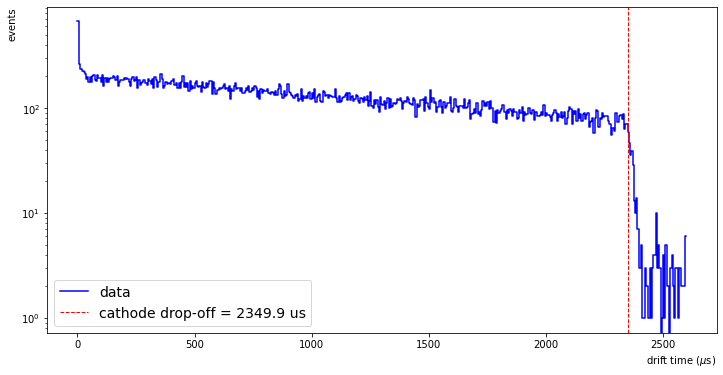

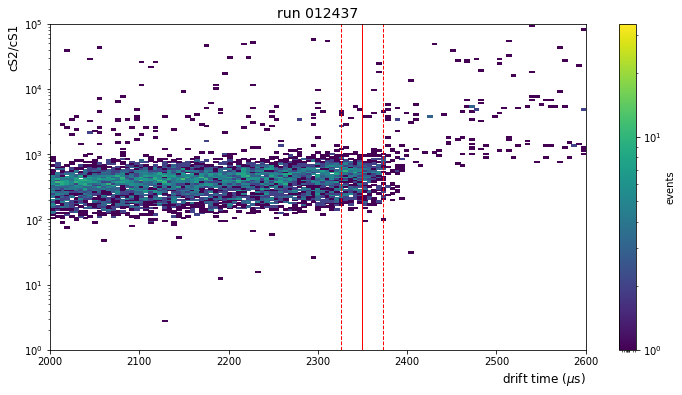

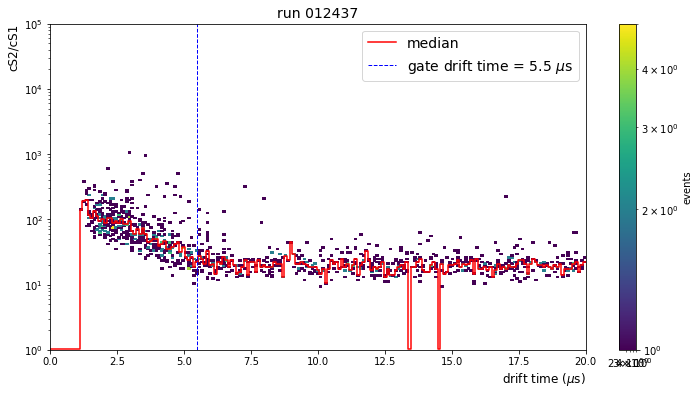

In [184]:
vd_kr = drift_velocity(e1, run_kr)

In [191]:
def diffusion_constant(events, run_id, fit_range, vd = 600):
    # s2_width_50 vs drift_time
    t = np.linspace(0, 2400, 200)
    ph = Histdd(events['drift_time']/1e3, events['s2_a_range_50p_area'],
                bins=(t, np.linspace(100, 15e3, 200)))
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run {run_id}',fontsize=14)
    
    #plt.plot(t[:len(mean)], mean, color='r',linestyle='-', label='mean per drift time slice')
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    plt.plot(t[:len(perc50)], perc50, color='b',linestyle='--', label='50% percentile')
    
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    print(f'Drift velocity = {vd:.3f} mm/$\mu$s ')
    vd = vd * units.mm / units.us
    guess = np.array([D_guess, vd, w0_guess])
    ys_m = ddu.diffusion_model(t, *guess)
    #plt.plot(t, ys_m, c='yellow',linestyle='--',label='initial guess')
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: ddu.diffusion_model(x, D, vd, w0)
    #popt, pcov = curve_fit(diffusion, t[ll:hh], mean[ll:hh], p0=(D_guess, w0_guess))
    popt, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    ys_u = diffusion(t, *popt) + 1000
    ys_m = diffusion(t, *popt)
    ys_d = diffusion(t, *popt) - 1000

    plt.plot(t, ys_m, label=f'$D = {popt[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s',color='r')
    #plt.plot(t, ys_u,color='r')
    #plt.plot(t, ys_d,color='r')
    plt.legend(fontsize=14)
    print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} +/- {perr[0]/1e3/(units.cm**2 / units.s):.2f} cm$^2$/s ')
    #print(f'Diffusion constant = {popt[0]/1e3/(units.cm**2 / units.s):.2f} cm^2/s ')
    print(f'w0 = {popt[1]/(units.ns):.2f} +/- {perr[1]/(units.ns):.2f} ns ')

Drift velocity = 0.633 mm/$\mu$s 
Diffusion constant = 43.19 +/- 0.13 cm$^2$/s 
w0 = 831.47 +/- 37.55 ns 


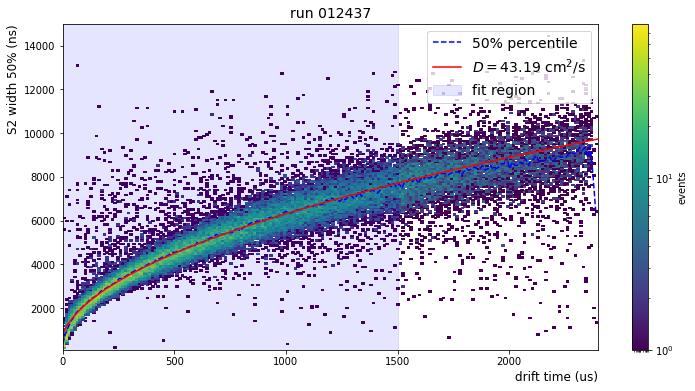

In [192]:
diffusion_constant(e2,run_kr,fit_range=(1,1500),vd = vd_kr)

In [198]:
def diffusion_analysis(run_kr,area_cut):
    events = st.get_array(run_kr,'event_info_double')
    mask_KrS1 = mask_KrSingleS1(events)
    e1 = events[mask_KrS1]
    mask_awt = mask_s2_area_width_aft(events,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77))
    e2 = events[mask_KrS1 & mask_awt]
    vd_kr = drift_velocity(e1, run_kr)
    diffusion_constant(e2,run_kr,fit_range=(1,1500),vd = vd_kr)

Loading event_info_double: |          | 0.00 % [00:00<?]

Drift velocity = 0.629 mm/$\mu$s
Drift velocity = 0.629 mm/$\mu$s 
Diffusion constant = 43.01 +/- 0.17 cm$^2$/s 
w0 = 1014.11 +/- 41.30 ns 


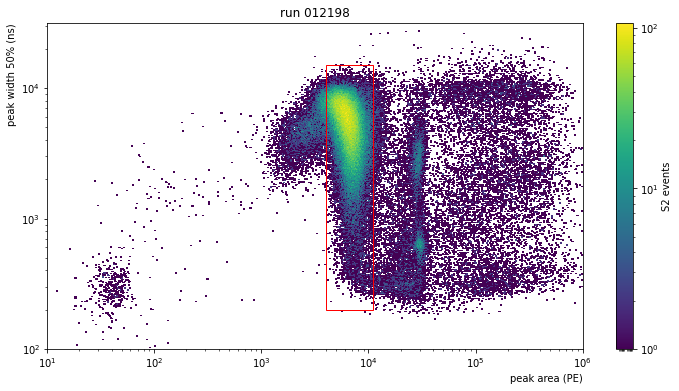

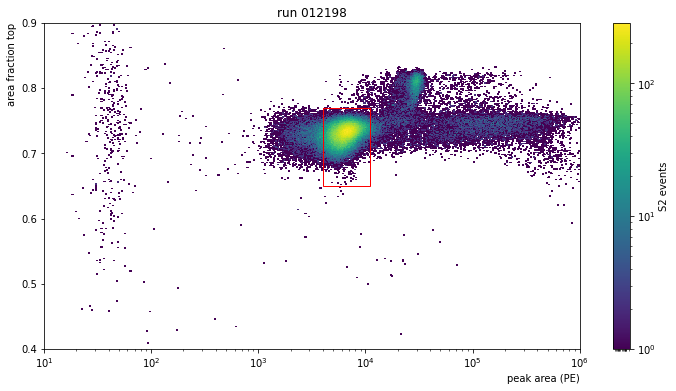

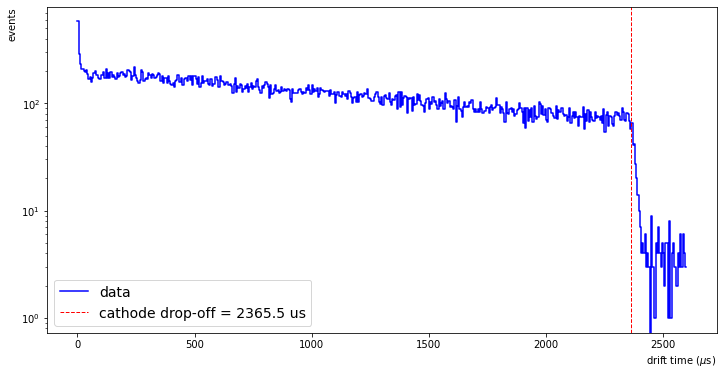

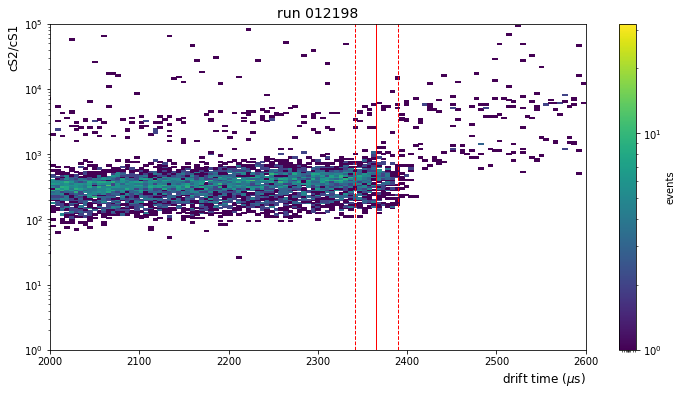

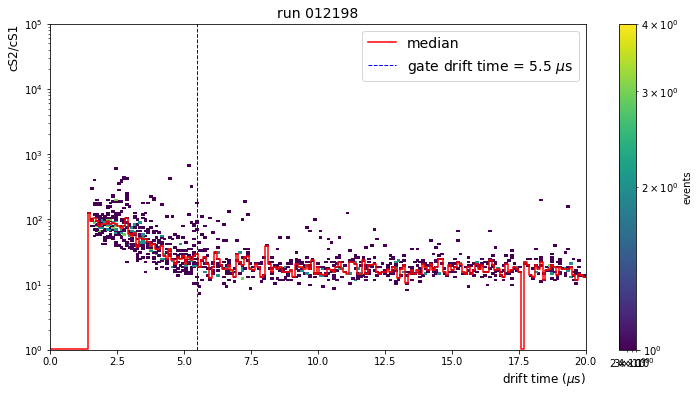

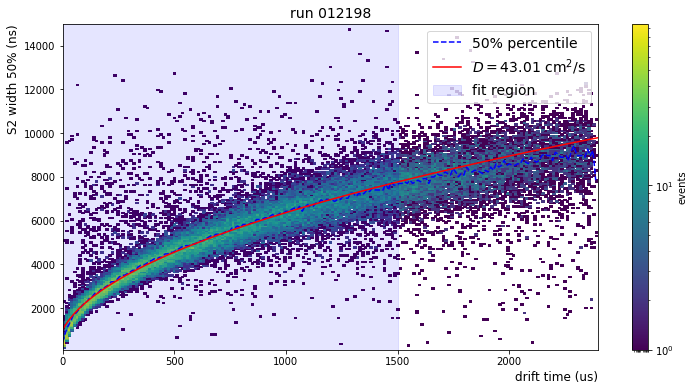

In [199]:
diffusion_analysis('012198',area_cut=(4e3,1.1e4))

Loading event_info_double: |          | 0.00 % [00:00<?]

Drift velocity = 5.094 mm/$\mu$s
Drift velocity = 5.094 mm/$\mu$s 
Diffusion constant = 2710.52 +/- 22.74 cm$^2$/s 
w0 = 0.08 +/- 2135088.35 ns 


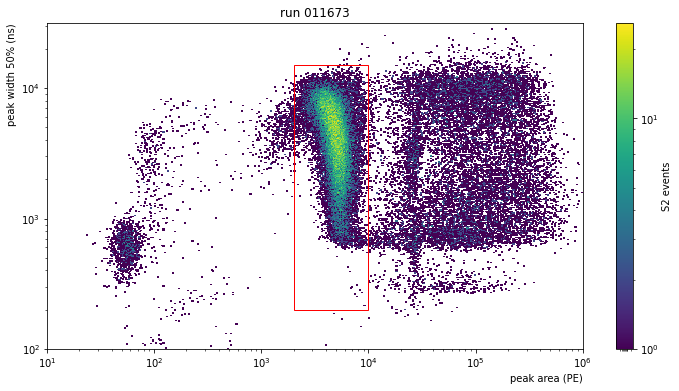

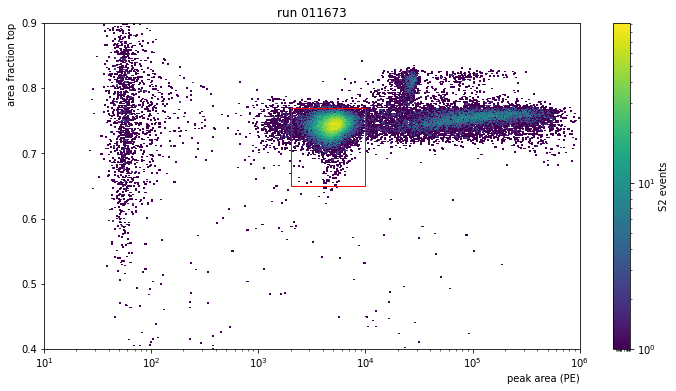

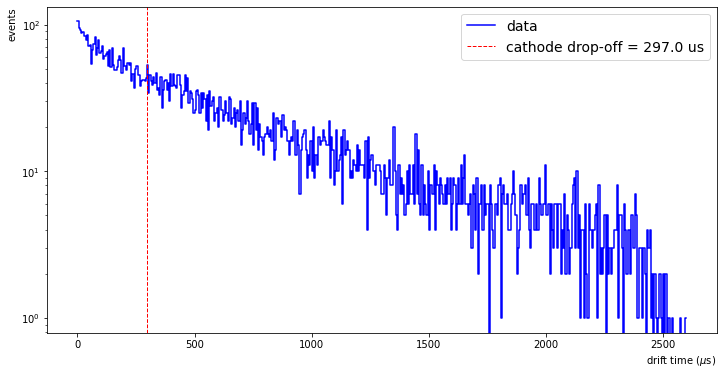

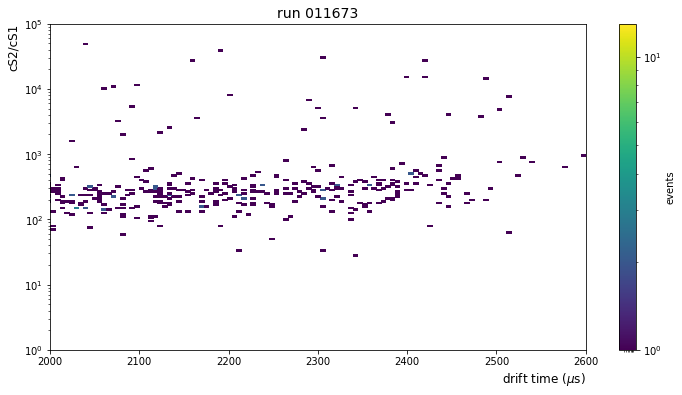

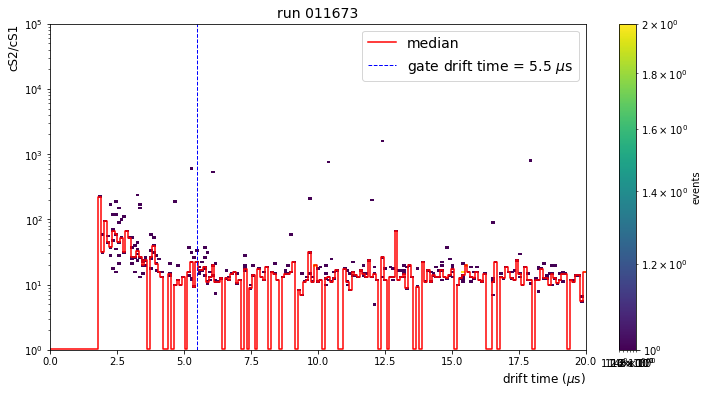

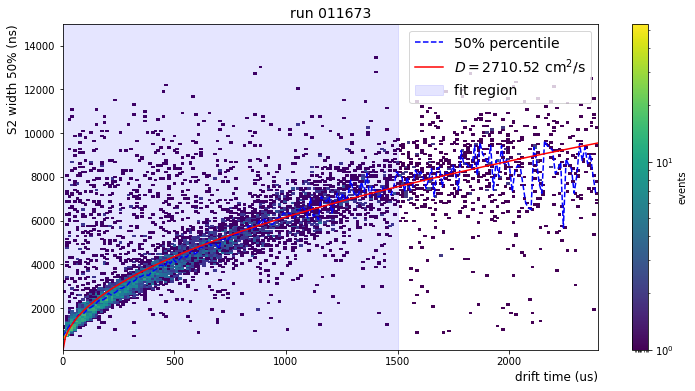

In [201]:
diffusion_analysis('011673',area_cut=(2e3,1e4))

# Cut S2 Width vs Drift Time

In [64]:
def s2width(dt, kind):
    "dt in us"
    if kind == "upper":
        # width = (800 ** 2 + (6000 ** 2 - 800 ** 2) / 800 * dt) ** 0.5 + 1100
        # width = (1000 ** 2 + (10500 ** 2 - 1000 ** 2) / 2400 * dt) ** 0.5 + 1100
        # from valerio's study
        width = _s2width(dt) + 1000
    elif kind == "lower":
        width = (800 ** 2 + (9200 ** 2 - 800 ** 2) / 2400 * dt) ** 0.5 - 1100
        # width = _s2width(dt) - 2000
    return width

def _s2width(t):
    """from valerio's study, https://xe1t-wiki.lngs.infn.it/doku.php?id=dandrea:krdata-s2event"""
    # assumed omega 0
    omega_0 = 1000  # us
    D = 51.89  # cm^2/s
    v = 0.63  # mm/us
    # output is ns
    coeff = 1e2
    width = np.sqrt(omega_0 ** 2 + 3.6395*D*t/v**2*coeff)
    return width

def AddS2WidthCut(df):
    mask_s2width = (df.s2_range_50p_area > s2width(df.drift_time/1e3, "lower")) \
                   & (df.s2_range_50p_area < s2width(df.drift_time/1e3, "upper"))
    # non-zero drif time
    mask_s2width &= df.drift_time > 0
    #df["CutS2Width"] = mask_s2width
    return mask_s2width

Loading event_info: |          | 0.00 % [00:00<?]

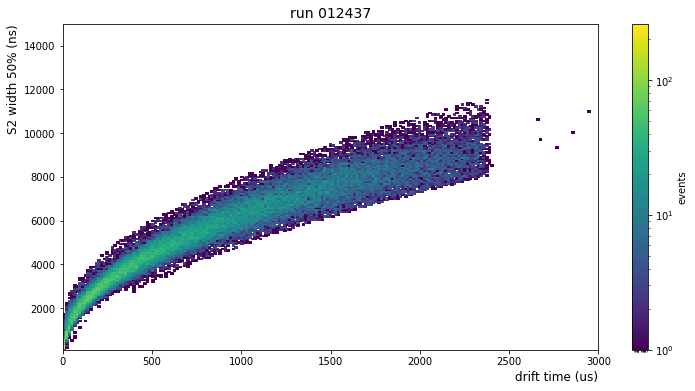

In [69]:
ev = st.get_df(run_kr,'event_info')
mask_s2width = AddS2WidthCut(ev)
ev2 = ev[mask_KrS1 & mask_s2width]
s2_width_vs_dt(ev2['drift_time']/1e3,ev2['s2_range_50p_area'],run_kr)

# Cut S1 Area Fraction Top vs Drift Time

In [135]:
def s1aft_dt_upper(dt):
    return dt*(0.65-0)/(0-3000) + 0.65

def s1aft_dt_lower(dt):
    return dt*(0.45-0.0)/(0-2000) + 0.45

def AddS1AFTCut(df):
    mask = (df.s1_area_fraction_top > s1aft_dt_lower(df.drift_time/1e3)) \
           & (df.s1_area_fraction_top < s1aft_dt_upper(df.drift_time/1e3))
    df["CutS1AFT"] = mask
    return df